In [53]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder, MNIST
from torchvision import transforms
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
from tensorboardX import SummaryWriter

import pandas as pd
import numpy as np
import random
from tqdm import tqdm_notebook
from collections import Counter, OrderedDict
from Reflectance_calculate import BARC_calculator

folder_path = '/home/users/parksangjoon/Desktop/sangjoon/pt/home/LithoAI/'

In [29]:
!nvidia-smi

Tue Dec 22 19:50:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 440.44       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:3B:00.0 Off |                  N/A |
| 31%   40C    P8    22W / 250W |   2664MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:D8:00.0 Off |                  N/A |
| 31%   26C    P8    20W / 250W |     53MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [30]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5), std=(0.5))
])

# 데이터 처리

In [31]:
data = pd.read_csv(folder_path + '/20200518_data_preprocessing/sangjoon/res_201014/BABCdata_condition_1.csv')
data = data.drop('Unnamed: 0', axis = 1)

In [32]:
data

,TE_r,TE_t,TM_r,TM_t,layer3,n3,k3,d3,layer2,n2,k2,d2,layer1,n1,k1,d1,anlge
0,69.8447,9.699340e-77,67.5426,1.123680e-76,3.0,1.7,0.015,0.0,2.0,1.8,0.016,0.0,1.0,0.8808,2.778,1000.0,20.0
1,61.7972,1.210240e-76,59.8416,1.369030e-76,3.0,1.7,0.015,0.0,2.0,1.8,0.016,5.0,1.0,0.8808,2.778,1000.0,20.0
2,48.8629,1.580240e-76,48.3188,1.718480e-76,3.0,1.7,0.015,0.0,2.0,1.8,0.016,10.0,1.0,0.8808,2.778,1000.0,20.0
3,35.0265,1.944880e-76,37.0732,2.027110e-76,3.0,1.7,0.015,0.0,2.0,1.8,0.016,15.0,1.0,0.8808,2.778,1000.0,20.0
4,32.2103,1.961420e-76,35.0591,2.022830e-76,3.0,1.7,0.015,0.0,2.0,1.8,0.016,20.0,1.0,0.8808,2.778,1000.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1771556,40.0914,1.227480e-76,39.4410,1.338590e-76,3.0,1.8,0.025,50.0,2.0,1.9,0.026,30.0,1.0,0.8808,2.778,1000.0,20.0
1771557,52.6551,9.429300e-77,50.5863,1.062610e-76,3.0,1.8,0.025,50.0,2.0,1.9,0.026,35.0,1.0,0.8808,2.778,1000.0,20.0
1771558,60.0517,7.835730e-77,57.4459,9.018210e-77,3.0,1.8,0.025,50.0,2.0,1.9,0.026,40.0,1.0,0.8808,2.778,1000.0,20.0
1771559,63.0859,7.209890e-77,60.2759,8.384830e-77,3.0,1.8,0.025,50.0,2.0,1.9,0.026,45.0,1.0,0.8808,2.778,1000.0,20.0


In [33]:
data['TE_r'] = list(map(round, data['TE_r'].values.tolist()))
# df1 = data[data['TE_r'] == 19]
# for i in range(20,29,1):
#     df2 = data[data['TE_r'] == i]
#     df1 = pd.concat([df1,df2])
    
# data = df1
data['TE_r'] = list(map(int,data['TE_r'].to_numpy()/10))
train_data = data.drop(['TE_r','TE_t','TM_r','TM_t','layer3','layer2','layer1'],
                                axis = 1)
train_label = data['TE_r']

In [34]:
#normalize

before_train_data_max = train_data.describe().loc['max'].to_numpy()
for i in train_data.columns:
    train_data[i] = train_data[i]/train_data.describe()[i]['max']

In [35]:
train_data.describe()

,n3,k3,d3,n2,k2,d2,n1,k1,d1,anlge
count,1.771561e+06,1.771561e+06,1.771561e+06,1.771561e+06,1.771561e+06,1.771561e+06,1771561.0,1771561.0,1771561.0,1771561.0
mean,9.722222e-01,8.000000e-01,5.000000e-01,9.736842e-01,8.076923e-01,5.000000e-01,1.0,1.0,1.0,1.0
std,1.756821e-02,1.264911e-01,3.162279e-01,1.664357e-02,1.216261e-01,3.162279e-01,0.0,0.0,0.0,0.0
min,9.444444e-01,6.000000e-01,0.000000e+00,9.473684e-01,6.153846e-01,0.000000e+00,1.0,1.0,1.0,1.0
25%,9.555556e-01,6.800000e-01,2.000000e-01,9.578947e-01,6.923077e-01,2.000000e-01,1.0,1.0,1.0,1.0
50%,9.722222e-01,8.000000e-01,5.000000e-01,9.736842e-01,8.076923e-01,5.000000e-01,1.0,1.0,1.0,1.0
75%,9.888889e-01,9.200000e-01,8.000000e-01,9.894737e-01,9.230769e-01,8.000000e-01,1.0,1.0,1.0,1.0
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0,1.0,1.0,1.0


In [36]:
train_label.describe()

count    1.771561e+06
mean     4.705567e+00
std      1.460221e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      6.000000e+00
max      7.000000e+00
Name: TE_r, dtype: float64

In [37]:
train_data

,n3,k3,d3,n2,k2,d2,n1,k1,d1,anlge
0,0.944444,0.6,0.0,0.947368,0.615385,0.0,1.0,1.0,1.0,1.0
1,0.944444,0.6,0.0,0.947368,0.615385,0.1,1.0,1.0,1.0,1.0
2,0.944444,0.6,0.0,0.947368,0.615385,0.2,1.0,1.0,1.0,1.0
3,0.944444,0.6,0.0,0.947368,0.615385,0.3,1.0,1.0,1.0,1.0
4,0.944444,0.6,0.0,0.947368,0.615385,0.4,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
1771556,1.000000,1.0,1.0,1.000000,1.000000,0.6,1.0,1.0,1.0,1.0
1771557,1.000000,1.0,1.0,1.000000,1.000000,0.7,1.0,1.0,1.0,1.0
1771558,1.000000,1.0,1.0,1.000000,1.000000,0.8,1.0,1.0,1.0,1.0
1771559,1.000000,1.0,1.0,1.000000,1.000000,0.9,1.0,1.0,1.0,1.0


# 데이터 텐서로 변환

In [38]:
class LithoDataset(torch.utils.data.Dataset):
    def __init__(self,input_data, input_label):
        self.y_data = input_label.to_numpy()
        self.x_data = input_data.to_numpy()
        
    def __len__(self):
        return len(self.x_data)
    
    
    def classes(self):
        classes_array = np.unique(self.y_data)
        
        return classes_array 
    
    
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.x_data[idx])
        x = x.reshape(1,10,1)
#         y = int(self.y_data[idx])//10 - 1
        y = int(self.y_data[idx]) - 1
        return x, y 

In [39]:
batch_size = 1024
dataset = LithoDataset(train_data, train_label)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle=True)
num_classes = len(dataset.classes())
print(num_classes)

7


# 모델 설정

In [40]:
class Discriminator(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.label_emb = nn.Embedding(num_classes, num_classes) #index out error를 위해 라벨의 최댓값 + 1로 지정
        
        self.model = nn.Sequential(
            nn.Linear(10+num_classes, 32), #83인 이유 : 데이터 dim 10 + 라벨 dim 73
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(32, 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(16, 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 10)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()


In [41]:
class Generator(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(10 + num_classes, 24), #173인 이유 : z dim 100 + 라벨 dim 73
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(24, 28),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(28, 32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(32, 10),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 10)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 1, 10)


In [42]:
generator = Generator(num_classes).cuda()
discriminator = Discriminator(num_classes).cuda()

In [43]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [44]:
writer = SummaryWriter()

In [45]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion, num_classes):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 10)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, num_classes-1, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

In [46]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels, num_classes):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())
    
    # train with fake images
    z = Variable(torch.randn(batch_size, 10)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, num_classes-1, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

# 학습

In [47]:
%%time

num_epochs = 50
n_critic = 5
display_step = 50
for epoch in tqdm_notebook(range(num_epochs)):
    print('Starting epoch {}...'.format(epoch), end=' ')
    
    for i, (images, labels) in enumerate(dataloader):
        step = epoch * len(dataloader) + i + 1
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        generator.train()
        
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels, num_classes)
        

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion, num_classes)
        
        writer.add_scalars('scalars', {'g_loss': g_loss, 'd_loss': d_loss}, step)  
        
        if step % display_step == 0:
            generator.eval()
            z = Variable(torch.randn(num_classes - 1, 10)).cuda()
            labels = Variable(torch.LongTensor(np.arange(num_classes - 1))).cuda()
            sample_images = generator(z, labels).unsqueeze(1)
            grid = make_grid(sample_images, nrow=3, normalize=True)
            writer.add_image('sample_image', grid, step)
    print('Done!')

/home/users/parksangjoon/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


Starting epoch 0... Done!
Starting epoch 1... Done!
Starting epoch 2... Done!
Starting epoch 3... Done!
Starting epoch 4... Done!
Starting epoch 5... Done!
Starting epoch 6... Done!
Starting epoch 7... Done!
Starting epoch 8... Done!
Starting epoch 9... Done!
Starting epoch 10... Done!
Starting epoch 11... Done!
Starting epoch 12... Done!
Starting epoch 13... Done!
Starting epoch 14... Done!
Starting epoch 15... Done!
Starting epoch 16... Done!
Starting epoch 17... Done!
Starting epoch 18... Done!
Starting epoch 19... Done!
Starting epoch 20... Done!
Starting epoch 21... Done!
Starting epoch 22... Done!
Starting epoch 23... Done!
Starting epoch 24... Done!
Starting epoch 25... Done!
Starting epoch 26... Done!
Starting epoch 27... Done!
Starting epoch 28... Done!
Starting epoch 29... Done!
Starting epoch 30... Done!
Starting epoch 31... Done!
Starting epoch 32... Done!
Starting epoch 33... Done!
Starting epoch 34... Done!
Starting epoch 35... Done!
Starting epoch 36... Done!
Starting ep

# Loss 그래프

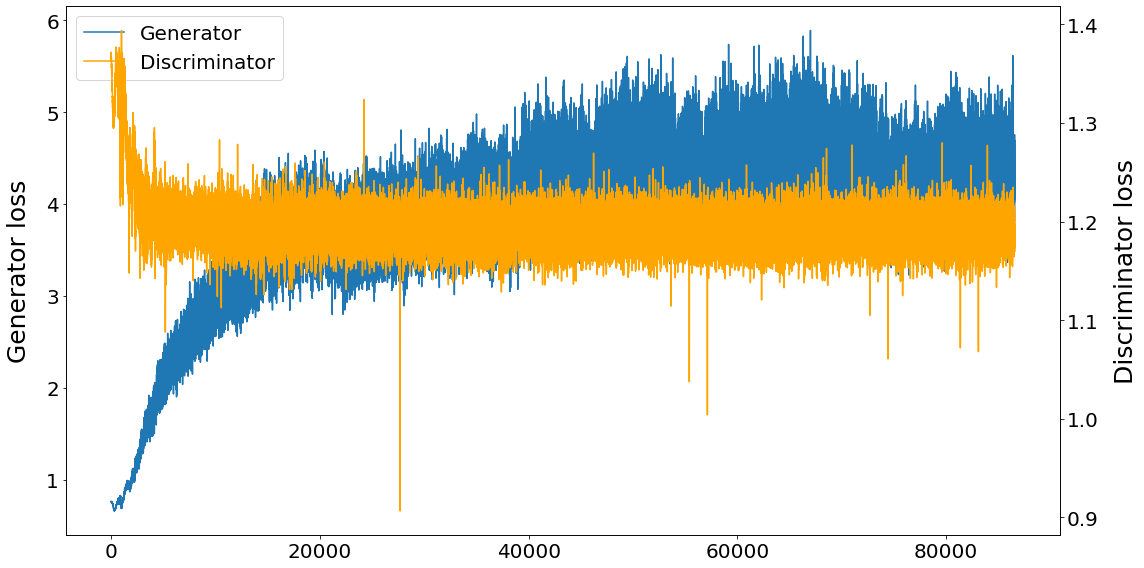

In [48]:
fig = plt.figure(figsize = [16,8])
ax1 = fig.add_subplot(111)

g_plot = ax1.plot(range(len(writer.scalar_dict[list(writer.scalar_dict.keys())[0]])),
                 np.array(writer.scalar_dict[list(writer.scalar_dict.keys())[0]])[:,2],
                 label = 'Generator')

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('Generator loss', fontsize = 25, labelpad = 15)

ax2 = ax1.twinx()
d_plot = ax2.plot(range(len(writer.scalar_dict[list(writer.scalar_dict.keys())[1]])),
                 np.array(writer.scalar_dict[list(writer.scalar_dict.keys())[1]])[:,2],
                 c = 'orange',
                 label = 'Discriminator')

total_plot = g_plot + d_plot
labels = [l.get_label() for l in total_plot]
plt.yticks(fontsize = 20)
plt.ylabel('Discriminator loss', fontsize = 25, labelpad = 15)
ax1.legend(total_plot, labels, fontsize = 20, loc = 'best')
plt.tight_layout()
plt.show()

# 모델 저장

In [18]:
torch.save(generator.state_dict(), 'generator_state_1024.pt')

# Generator로 이미지 생성

> 여러 이미지

In [65]:
z = Variable(torch.randn(100, 10)).cuda()
labels = torch.LongTensor([i for i in range(10) for _ in range(10)]).cuda()

In [66]:
images = generator(z, labels).unsqueeze(1)

In [67]:
grid = make_grid(images, nrow=10, normalize=True)

RuntimeError: cuda runtime error (710) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1595629403081/work/aten/src/THC/THCCachingHostAllocator.cpp:278

(-0.5, 121.5, 31.5, -0.5)

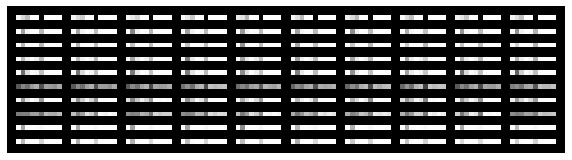

In [429]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(grid.permute(1, 2, 0).data.cpu(), cmap='binary')
ax.axis('off')

> 이미지 한개 생성

In [52]:
def generate_digit(generator, digit):
    z = Variable(torch.randn(1, 10)).cuda()
    label = torch.LongTensor([digit]).cuda()
    img = generator(z, label).data.cpu()
    img = 0.5 * img + 0.5
    #return transforms.ToPILImage()(img)
    return img

In [50]:
print(list(range(num_classes)))

[0, 1, 2, 3, 4, 5, 6]


In [68]:
wave_length = 193
result_list = []
true_label = []
for i in range(100):
    result = generate_digit(generator, 4).reshape(10).numpy()*before_train_data_max
    result_list.append(result)
    cal_data = np.hstack([np.array([3,2,1]).reshape(3,-1),result[:-1].reshape(3,-1)])
    cal_data = pd.DataFrame(cal_data, columns = ['layer','n','k','d'])
    cal_data = cal_data.astype({'layer': 'int'})
    true_label.append(BARC_calculator(cal_data, wave_length, result[-1])[0])

RuntimeError: CUDA error: device-side assert triggered

In [64]:
true_label

[66.11540515324221,
 5.234154549060962,
 39.43178656618098,
 68.38306836973602,
 47.7162313869229,
 46.08603850882569,
 38.57778300593331,
 65.32954201650482,
 65.53373569568463,
 2.8234582200092535,
 50.127153178241,
 47.3514681431868,
 73.55933814919842,
 65.5083070628615,
 66.8580845426095,
 10.985211880021865,
 24.59384466182188,
 65.0325068274842,
 80.9332618495338,
 39.00358331351892,
 24.991617767713315,
 55.82876602979998,
 72.86250097148033,
 63.06722576039632,
 72.91531249649009,
 20.392160103564482,
 81.80690800352568,
 71.35657280715554,
 69.13041032683039,
 67.58607733817239,
 70.42702541973914,
 75.94589927750775,
 58.909798475303774,
 25.367900114127444,
 11.591232590993839,
 54.186718068712516,
 4.265927278170552,
 57.8908044324587,
 31.132508682215892,
 75.49220496320206,
 24.37288332594683,
 65.48555112311485,
 61.87024026022002,
 12.98784782081402,
 77.66801421878034,
 68.73390137148687,
 57.127618307409456,
 50.37089685324966,
 4.1377682579213335,
 65.45506711502591

In [58]:
df = pd.DataFrame(result_list[8].reshape(1,10), columns = ['n3','k3','d3','n2','k2','d2','n1','k1','d1','angle'])
df

,n3,k3,d3,n2,k2,d2,n1,k1,d1,angle
0,1.783092,0.021254,40.863985,1.823312,0.023677,44.41196,0.8808,2.778,1000.0,20.0
